In [1]:
import pandas as pd
import seaborn as sns
import os
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
from IPython.display import Image
import librosa
import librosa.display
import sklearn
import numpy as np


In [2]:
%store -r top_tracks
pd.set_option('display.max_colwidth', None)
top_tracks['preview_url']

1     https://p.scdn.co/mp3-preview/59f68f3e96233e3c352659053dd48039790cd965?cid=5f736022721243569883acdc831ebc90
2     https://p.scdn.co/mp3-preview/fc780d2d7634024c170723c769cca145d298e53f?cid=5f736022721243569883acdc831ebc90
3     https://p.scdn.co/mp3-preview/6890d6f0749ecec39ce0bc1811b144ba1c19f7ee?cid=5f736022721243569883acdc831ebc90
4     https://p.scdn.co/mp3-preview/8fc181a40905456c5d8084ba2fe26e469319baba?cid=5f736022721243569883acdc831ebc90
5     https://p.scdn.co/mp3-preview/c98feacb51b83d5a0490ea9886a5b25a7f4afec7?cid=5f736022721243569883acdc831ebc90
6     https://p.scdn.co/mp3-preview/dac105442fc83b3b2a8cbd238ffa9d898d73e805?cid=5f736022721243569883acdc831ebc90
7     https://p.scdn.co/mp3-preview/150814aafbffda9f179776fba32b4620b4d87c1a?cid=5f736022721243569883acdc831ebc90
8     https://p.scdn.co/mp3-preview/3cc58eff7a43e53f29af0f5fb0dc29f76c6819c5?cid=5f736022721243569883acdc831ebc90
9     https://p.scdn.co/mp3-preview/37beb1785c5a3f9fa734af22d64571d42449fe22?cid=5f73602

In [3]:
#just importing the top 50 tracks from my own personal data

output_folder = 'tracks'
os.makedirs(output_folder, exist_ok=True)

def download_mp3(url, filename):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Check if the request was successful

        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")

# Download each URL
for i, track in enumerate(top_tracks['preview_url']):
    filename = os.path.join(output_folder, f"track_{i+1}.mp3")
    download_mp3(track, filename)


Downloaded tracks/track_1.mp3
Downloaded tracks/track_2.mp3
Downloaded tracks/track_3.mp3
Downloaded tracks/track_4.mp3
Downloaded tracks/track_5.mp3
Downloaded tracks/track_6.mp3
Downloaded tracks/track_7.mp3
Downloaded tracks/track_8.mp3
Downloaded tracks/track_9.mp3
Downloaded tracks/track_10.mp3
Downloaded tracks/track_11.mp3
Downloaded tracks/track_12.mp3
Downloaded tracks/track_13.mp3
Downloaded tracks/track_14.mp3
Downloaded tracks/track_15.mp3
Downloaded tracks/track_16.mp3
Downloaded tracks/track_17.mp3
Downloaded tracks/track_18.mp3
Downloaded tracks/track_19.mp3
Downloaded tracks/track_20.mp3
Downloaded tracks/track_21.mp3
Downloaded tracks/track_22.mp3
Downloaded tracks/track_23.mp3
Downloaded tracks/track_24.mp3
Downloaded tracks/track_25.mp3
Downloaded tracks/track_26.mp3
Downloaded tracks/track_27.mp3
Downloaded tracks/track_28.mp3
Downloaded tracks/track_29.mp3
Downloaded tracks/track_30.mp3
Downloaded tracks/track_31.mp3
Downloaded tracks/track_32.mp3
Downloaded tracks

**Data Description**

genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)

images original - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible (we'll be talking about this more in depth later)

2 CSV files - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file (more in depth later). The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better


In [4]:
import os
general_path = './GTZAN/'
print(list(os.listdir(f'{general_path}/genres_original/')))

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']


__PreProcessing__

In [5]:
print(tf.__version__)
print(tfio.__version__)
print(os.environ['PATH'])
#make sure the tf and tfio are compatible versions that use the same python interpreter, can check on tensorflow github
#can run juypter server by running in terminal "juypter notebook" and then launching kernel with that local http url

2.16.1
0.37.0
/usr/local/bin:/Users/fluffy/Library/Python/3.11/bin:/Library/Frameworks/Python.framework/Versions/3.12/bin:/Library/Frameworks/Python.framework/Versions/3.11/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/Apple/usr/bin:/Library/Frameworks/Python.framework/Versions/3.12/bin:/Library/Frameworks/Python.framework/Versions/3.11/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Users/fluffy/.nvm/versions/node/v18.18.0/bin:/path/to/driver:/Library/Frameworks/Python.framework/Versions/3.12/bin:/Library/Frameworks/Python.framework/Versions/3.11/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.crypt

./GTZAN/genres_original/hiphop/hiphop.00065.wav
sample rate  22050
data: [-0.9885559  -0.9885559  -0.9885559  ...  0.08666992  0.1022644
  0.14709473] 

data max:  0.9885559
data min:  -0.9885559
data shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


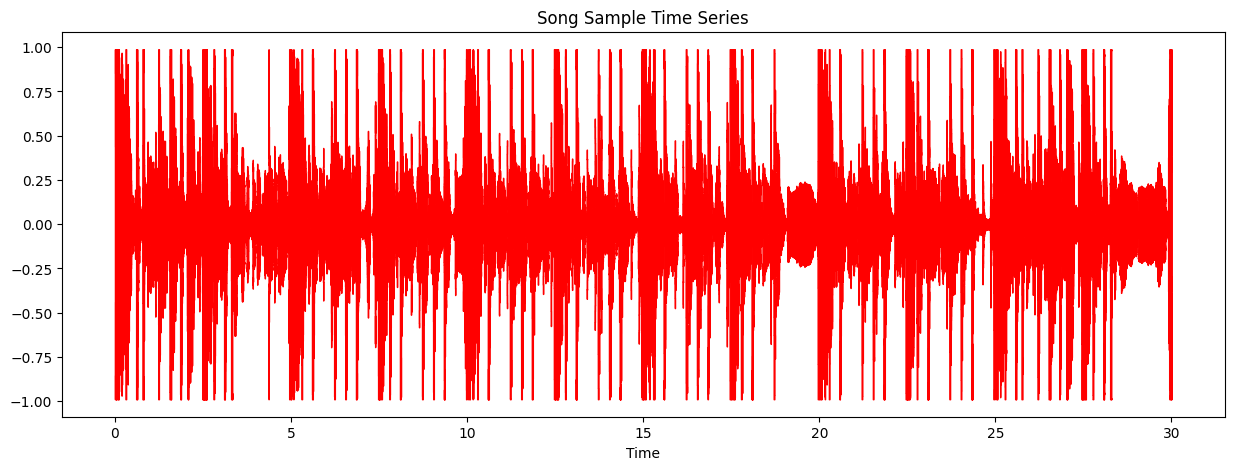

In [6]:
filename = os.path.join(general_path, 'genres_original', 'hiphop', 'hiphop.00065.wav')
print(filename)
data, sample_rate = librosa.load(filename)
#our data is a sequence of vibrations with varying amplitude/periods which we can represent numerically over time
#sample rate is how many times per second our audio is being sampled, which is about 22 kHz (kilohertz)
print('sample rate ', sample_rate)
print('data:', data, '\n')
print('data max: ' , max(data))
print('data min: ' , min(data))
#librosa normalizes it from range (-1,1) to mono channel 

print('data shape:', np.shape(data), '\n')
print('Sample Rate (KHz):', sample_rate, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(data)[0]/sample_rate)
plt.figure(figsize=(15,5))
plt.title('Song Sample Time Series')
librosa.display.waveshow(y = data, sr=sample_rate, color = 'red')
ipd.Audio(filename)


In [7]:
trimmed_audio, _ = librosa.effects.trim(data)
#returns a numpy array that has taken away leading and trailing silence so we only have necessary audio components, will save us time

print('Audio File:', trimmed_audio, '\n')
print('Audio File shape:', np.shape(trimmed_audio))


Audio File: [-0.9885559  -0.9885559  -0.9885559  ...  0.08666992  0.1022644
  0.14709473] 

Audio File shape: (661794,)


In [8]:
#perform fourier transform which returns a signal in time-frequency domain by computing over short windows/frames
 
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(trimmed_audio, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


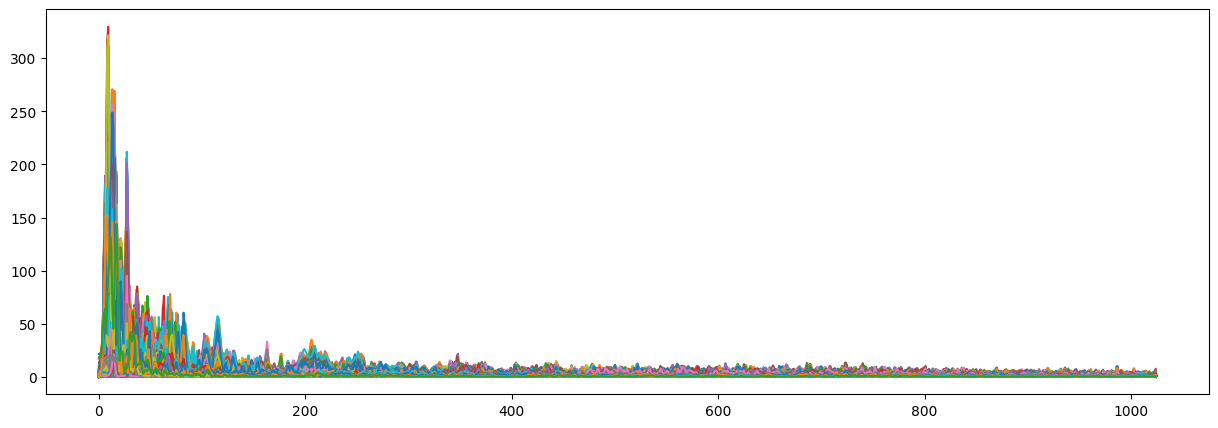

In [9]:
plt.figure(figsize = (15, 5))
plt.plot(D);

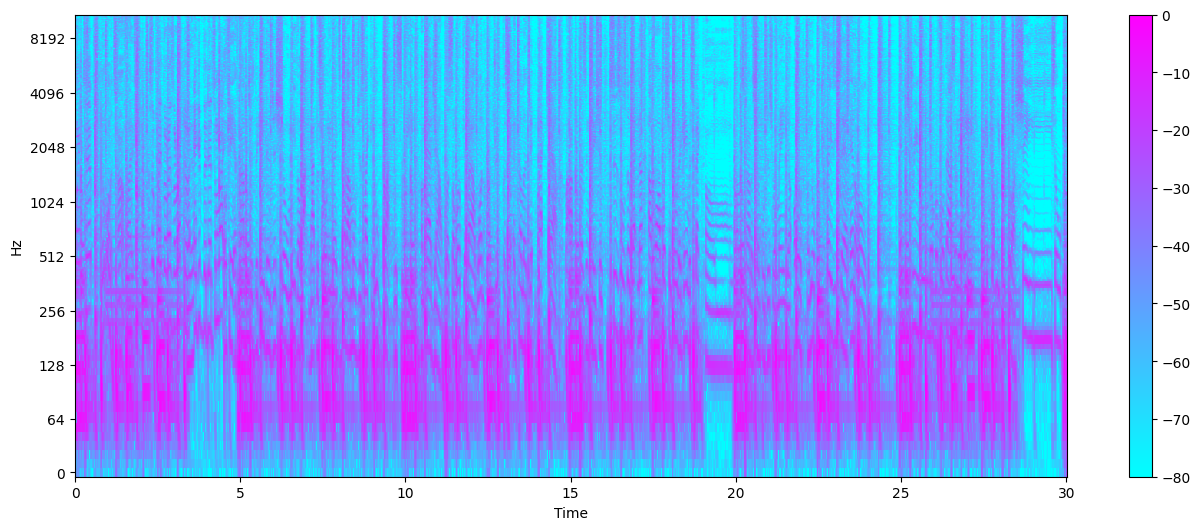

In [10]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram
# visual representation of frequency spectrum over time 
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sample_rate, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();


**Extract Features**


Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [11]:
zero_crossings = librosa.zero_crossings(trimmed_audio, pad=False)
print(sum(zero_crossings))
#total zero crossings in our song

58669


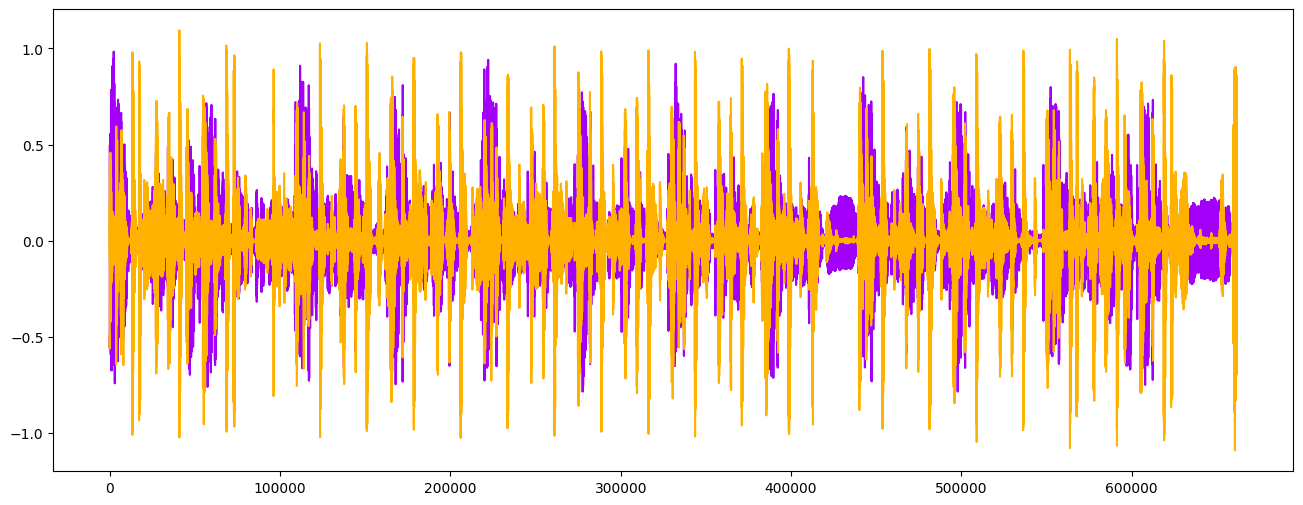

In [12]:
y_harm, y_perc = librosa.effects.hpss(trimmed_audio)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

In [13]:
tempo, beats = librosa.beat.beat_track(y = data, sr= sample_rate)
print(tempo)

onset_env = librosa.onset.onset_strength(y=data, sr=sample_rate)
tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sample_rate)
print(tempo)


[95.703125]
[95.703125]


In [14]:
spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sample_rate)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)


Centroids: [2246.76195467 1770.93710077 1338.33840427 ... 2082.57251103 1786.16895316
 1194.44944227] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


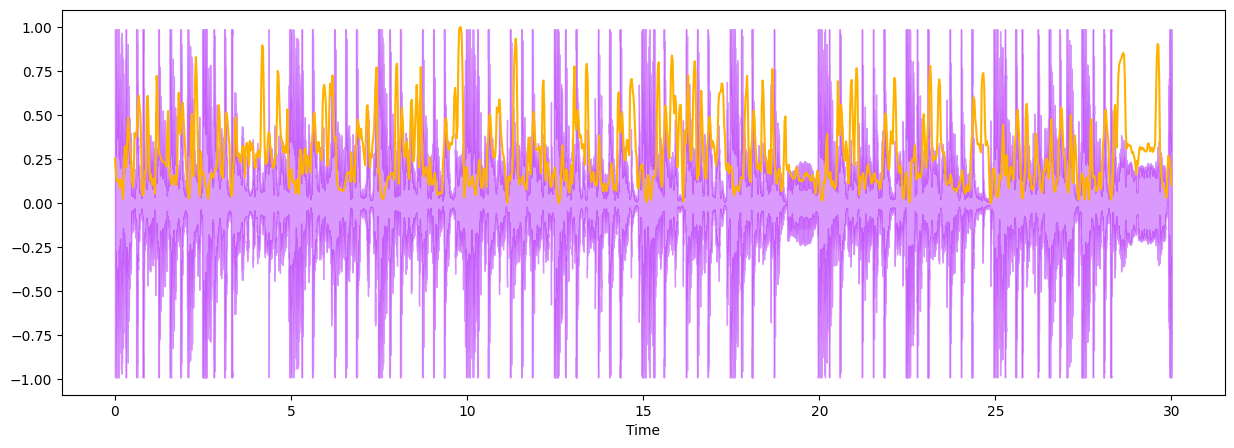

In [15]:
plt.figure(figsize = (15, 5))
librosa.display.waveshow(trimmed_audio, sr=sample_rate, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100');

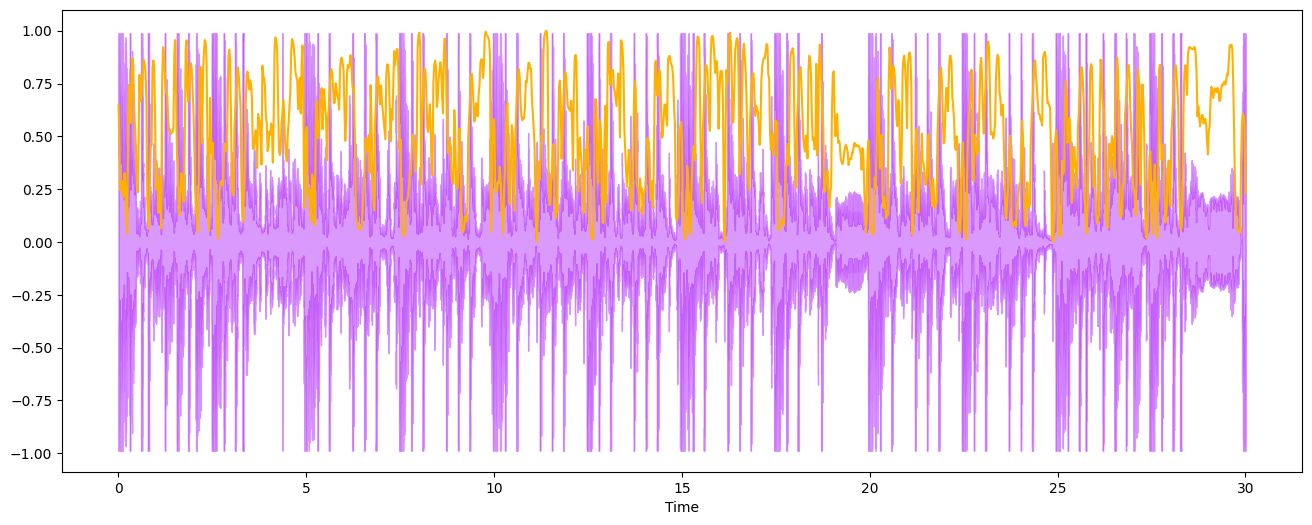

In [16]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(y = trimmed_audio, sr=sample_rate)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(trimmed_audio, sr=sample_rate, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

(50, 1293)


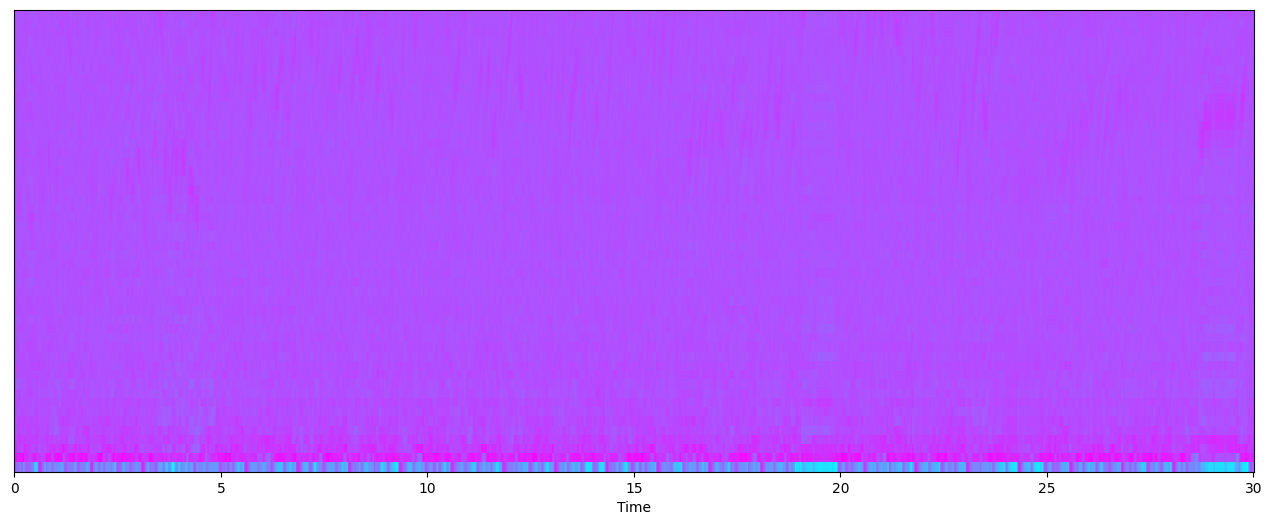

In [17]:
mfccs = librosa.feature.mfcc(y = data, sr= sample_rate, n_mfcc = 50)
print(mfccs.shape)
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap = 'cool');

In [18]:

mfccs


array([[-7.5226345e+00, -2.1238747e+01, -5.8244507e+01, ...,
         1.1312527e+01, -3.2126652e+01, -7.7432304e+01],
       [ 9.7127853e+01,  1.0944197e+02,  1.2764851e+02, ...,
         8.7575806e+01,  9.5958344e+01,  1.1644565e+02],
       [ 4.5077179e+01,  5.8259392e+01,  5.3558510e+01, ...,
         4.2545845e+01,  5.8617470e+01,  5.7103592e+01],
       ...,
       [-6.0244679e-02,  1.1084729e+00,  3.6587684e+00, ...,
         1.3381534e+00,  1.7780159e+00,  3.4465592e+00],
       [-9.3692744e-01, -1.1599997e+00, -4.0518675e+00, ...,
        -2.8640504e+00, -1.0972471e+00, -9.3815118e-02],
       [-4.6004066e+00, -6.5422115e+00, -5.5730753e+00, ...,
         8.9291978e-01, -2.8310685e+00, -2.5487316e+00]], dtype=float32)

Mean: -1.0620966e-09 

Var: 1.0000001


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


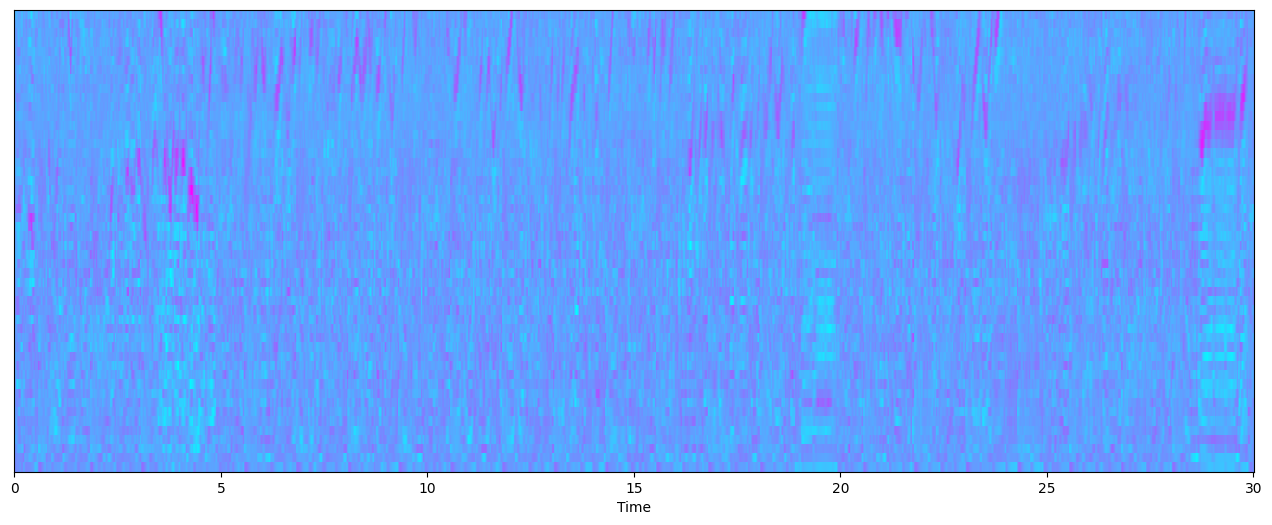

In [19]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap = 'cool');

Chromogram shape: (12, 133)


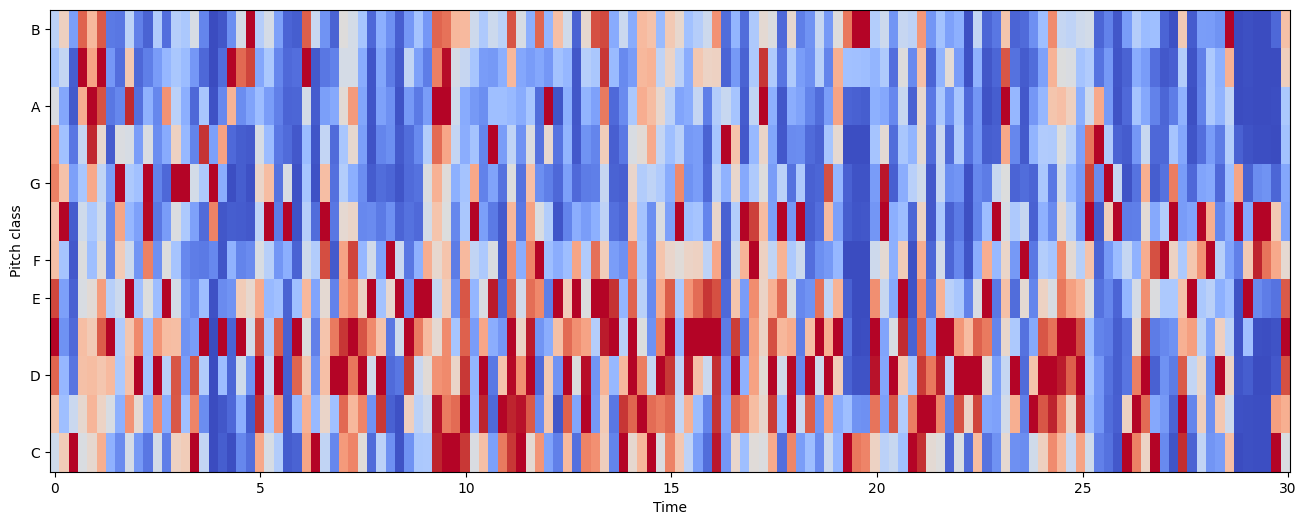

In [20]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(y = trimmed_audio, sr=sample_rate, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

In [22]:
df = pd.read_csv(f'{general_path}/features_30_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

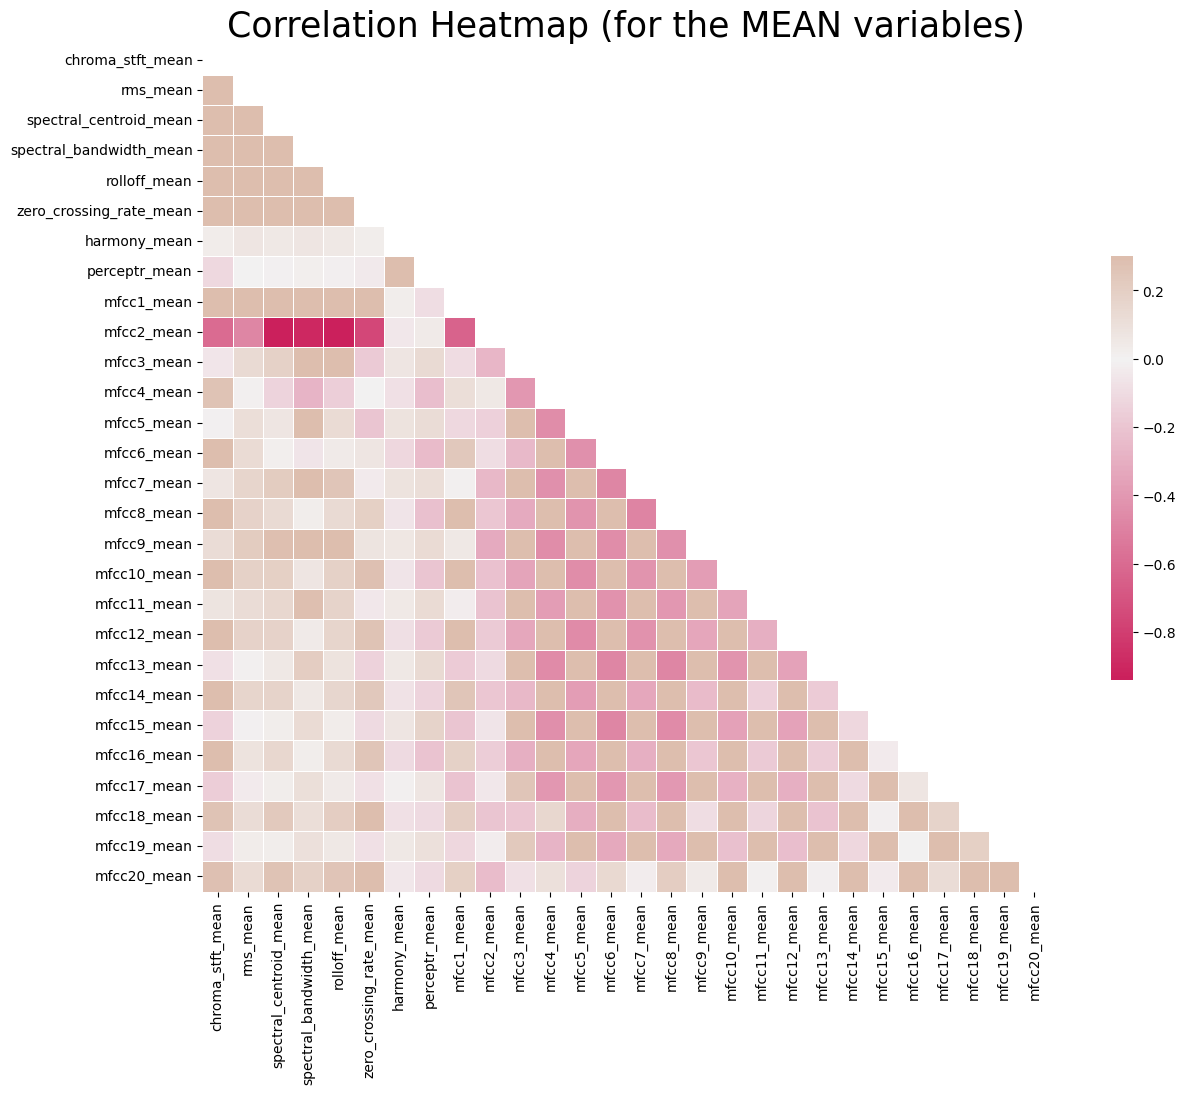

In [24]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle, since correlation is symmetric and we only need half
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

/var/folders/mq/p3_y68_d1bb8g6lqc0mjl_480000gn/T/ipykernel_92942/4037025743.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Library/Frameworks/Python.framework/Versions

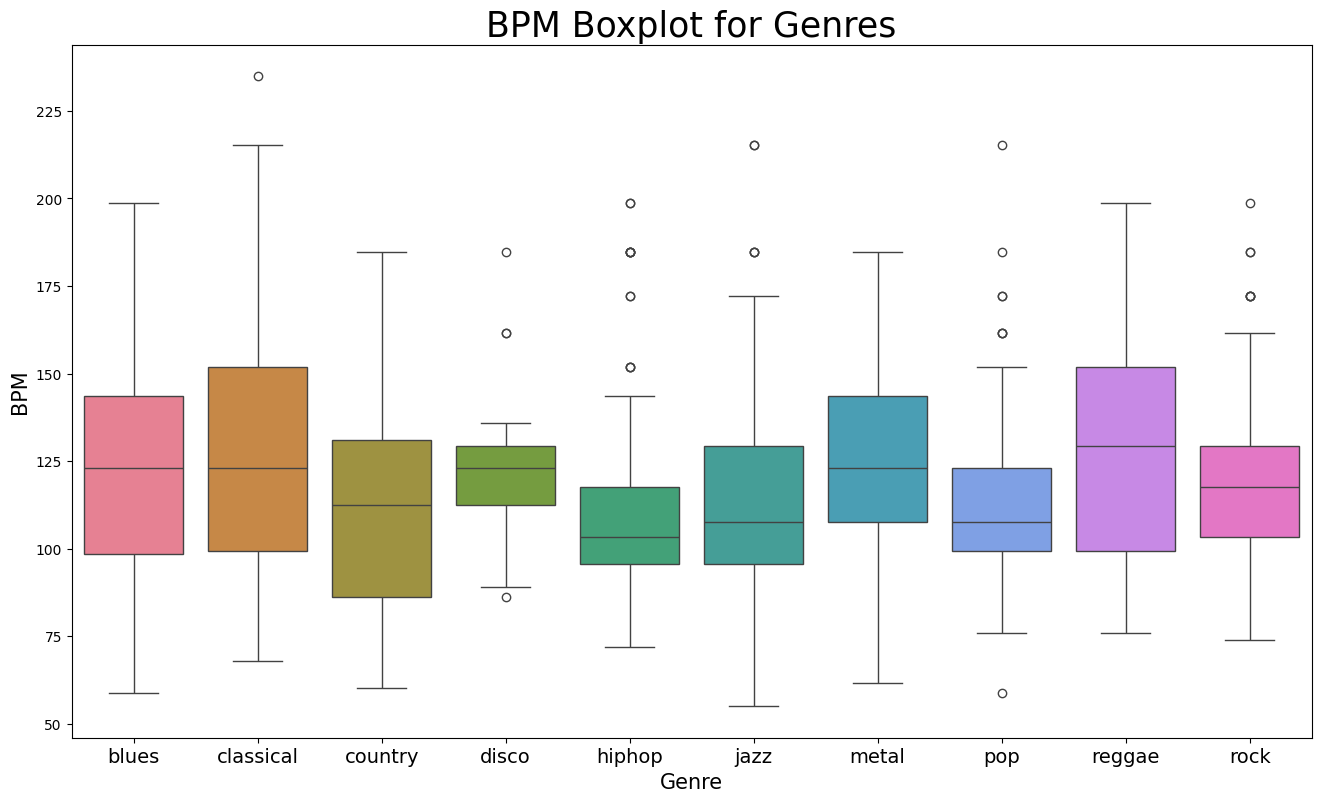

In [27]:
x = df[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

In [28]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

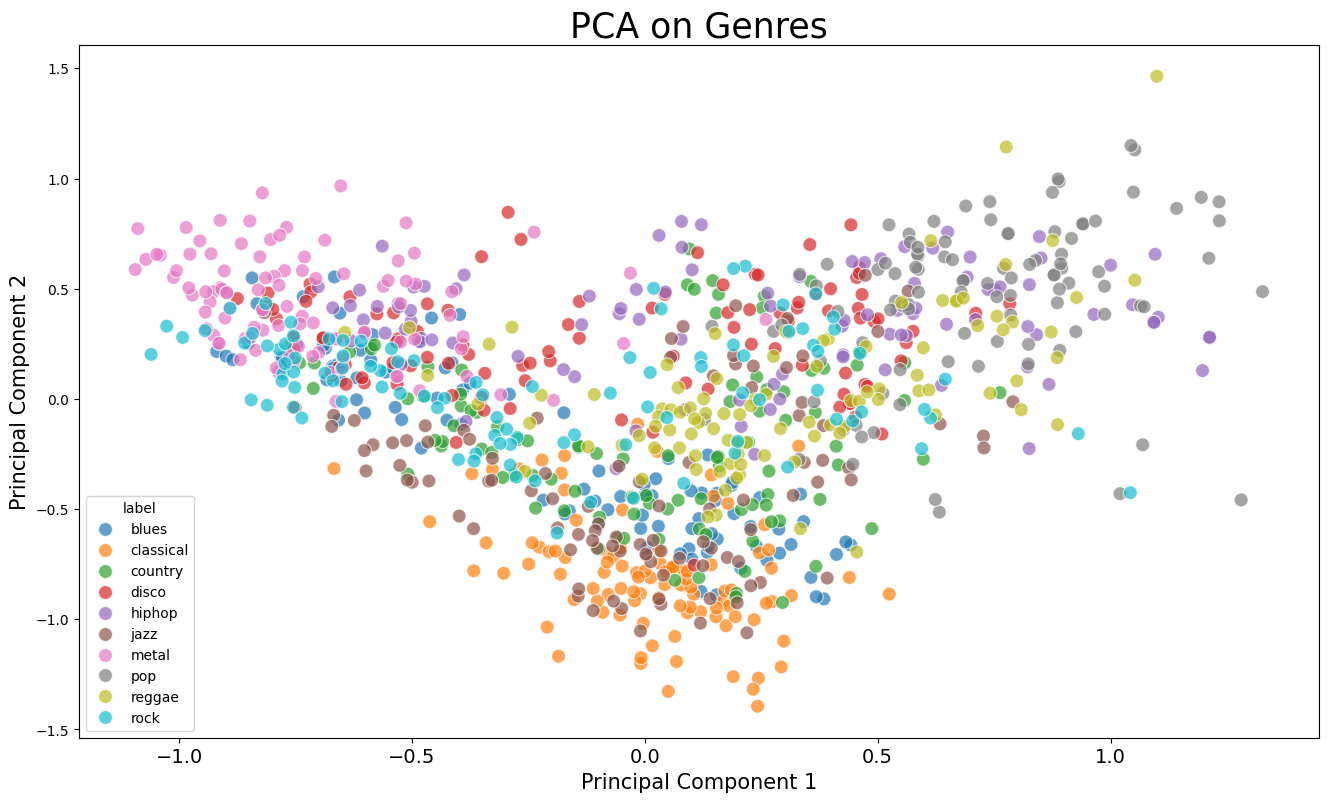

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")


In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE


In [48]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767  blues  
1   59.943081  blues  
2   33.105122  blues  
3   32.023678  blues  
4   29.146694  blues  

[5 rows x 59 columns]

In [49]:
#features and target variable

y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [50]:
#we'll use 60 40 train test spliot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [51]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [53]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decision trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")



Accuracy Naive Bayes : 0.52077 

Accuracy Stochastic Gradient Descent : 0.63614 

Accuracy KNN : 0.78829 

Accuracy Decision trees : 0.62888 

Accuracy Random Forest : 0.79955 

Accuracy Support Vector Machine : 0.73423 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression : 0.67793 

Accuracy Neural Nets : 0.64615 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [54]:
from sklearn.preprocessing import LabelEncoder

# Example of Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now, y_train_encoded and y_test_encoded contain numeric labels suitable for XGBClassifier

# Assuming X_train, X_test, y_train_encoded, y_test_encoded are defined

# Your model_assess function remains the same
def model_assess(model, title="Default"):
    model.fit(X_train, y_train_encoded)
    preds = model.predict(X_test)
    print('Accuracy', title, ':', round(accuracy_score(y_test_encoded, preds), 5), '\n')

# Using XGBClassifier with encoded labels
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Using XGBRFClassifier (Random Forest variant) with encoded labels
xgbrf = XGBRFClassifier(objective='multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")


Accuracy Cross Gradient Booster : 0.89089 

Accuracy Cross Gradient Booster (Random Forest) : 0.73373 



Our Best Model is the Accuracy Cross Gradient Booster with 0.89% accuracy on our test

Accuracy Cross Gradient Booster : 0.89089 



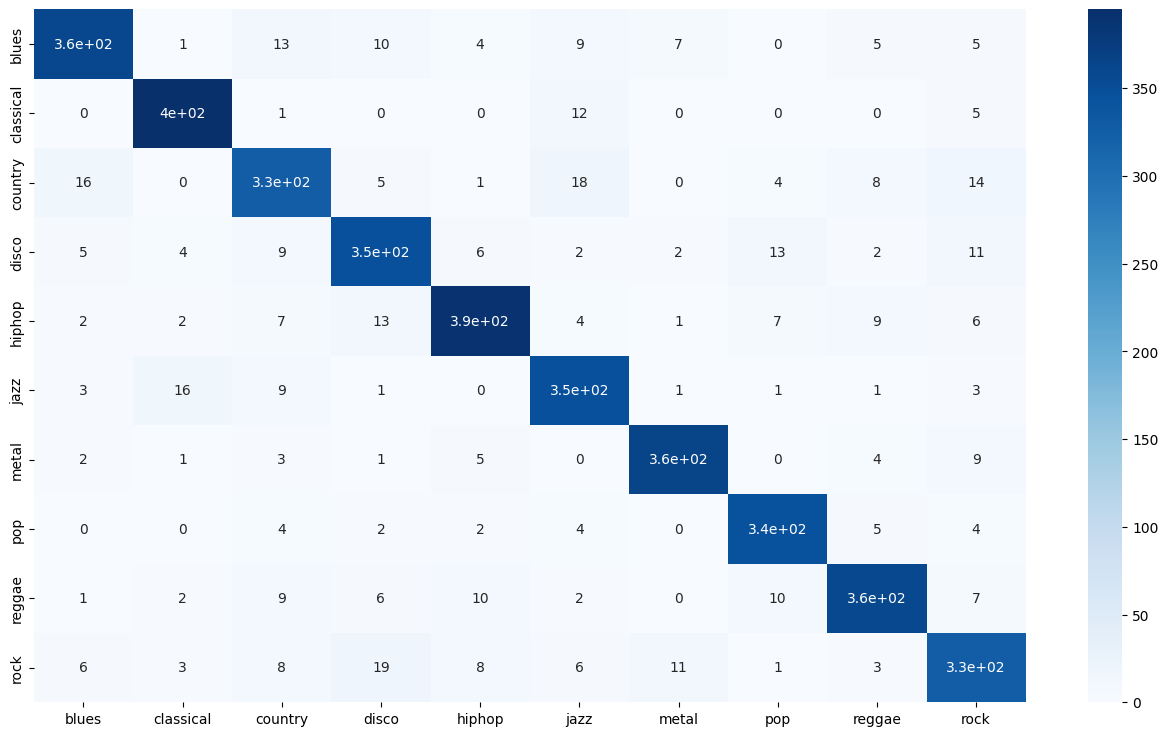

In [57]:
#FINAL MODEL
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def model_assess(model, title="Default"):
    model.fit(X_train, y_train_encoded)
    preds = model.predict(X_test)
    print('Accuracy', title, ':', round(accuracy_score(y_test_encoded, preds), 5), '\n')
    return preds

# Using XGBClassifier with encoded labels
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
preds = model_assess(xgb, "Cross Gradient Booster")

confusion_matr = confusion_matrix(y_test_encoded, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

In [58]:
# Make a recommender which will match a given song to the closest song
# Libraries
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

# Read data
data = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['length','label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

Scaled data type: <class 'numpy.ndarray'>


In [59]:
# Cosine similarity
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

Similarity shape: (1000, 1000)


filename         blues.00000.wav  blues.00001.wav  blues.00002.wav  \
filename                                                             
blues.00000.wav         1.000000         0.049231         0.589618   
blues.00001.wav         0.049231         1.000000        -0.096834   
blues.00002.wav         0.589618        -0.096834         1.000000   
blues.00003.wav         0.284862         0.520903         0.210411   
blues.00004.wav         0.025561         0.080749         0.400266   

filename         blues.00003.wav  blues.00004.wav  blues.00005.wav  \
filename                                                             
blues.00000.wav         0.284862         0.025561        -0.346688   
blues.00001.wav         0.520903         0.080749         0.307856   
blues.00002.wav         0.210411         0.400266        -0.082019   
blues.00003.wav         1.000000         0.126437         0.134796   
blues.00004.wav         0.126437         1.000000         0.556066   

filename         blues.00006.wav  blues.00007.wav  blues.00008.wav  \
filename                                                             
blues.00000.wav        -0.219483        -0.167626         0.641877   
blues.00001.wav         0.318286         0.415258         0.120649   
blues.00002.wav        -0.028061         0.104446         0.468113   
blues.00003.wav         0.300746         0.324566         0.352758   
blues.00004.wav         0.482195         0.623455         0.029703   

filename         blues.00009.wav  ...  rock.00090.wav  rock.00091.wav  \
filename                          ...                                   
blues.00000.wav        -0.097889  ...       -0.082829        0.546169   
blues.00001.wav         0.404168  ...       -0.098111       -0.325126   
blues.00002.wav        -0.132532  ...       -0.032408        0.561074   
blues.00003.wav         0.295184  ...       -0.320107       -0.206516   
blues.00004.wav         0.471657  ...        0.087605        0.017366   

filename         rock.00092.wav  rock.00093.wav  rock.00094.wav  \
filename                                                          
blues.00000.wav        0.578558        0.662590        0.571629   
blues.00001.wav       -0.370792       -0.191698       -0.330834   
blues.00002.wav        0.590779        0.583293        0.514537   
blues.00003.wav       -0.151132        0.041986       -0.172515   
blues.00004.wav        0.138035        0.104684       -0.034594   

filename         rock.00095.wav  rock.00096.wav  rock.00097.wav  \
filename                                                          
blues.00000.wav        0.610942        0.640835        0.496294   
blues.00001.wav       -0.077301       -0.222119       -0.302573   
blues.00002.wav        0.495707        0.566837        0.589983   
blues.00003.wav       -0.000287        0.020515       -0.107821   
blues.00004.wav        0.063454        0.063546        0.172944   

filename         rock.00098.wav  rock.00099.wav  
filename                                         
blues.00000.wav        0.284958        0.304098  
blues.00001.wav        0.499562        0.311723  
blues.00002.wav        0.216378        0.321069  
blues.00003.wav        0.502279        0.183210  
blues.00004.wav        0.153192        0.061785  

[5 rows x 1000 columns]

In [60]:
def find_similar_songs(name):
    # Find songs most similar to another song
    series = sim_df_names[name].sort_values(ascending = False)
    
    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(name)
    
    # Display the 5 top matches 
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))

In [61]:
find_similar_songs('pop.00019.wav') 

ipd.Audio(f'{general_path}/genres_original/pop/pop.00019.wav')


*******
Similar songs to  pop.00019.wav
filename
pop.00023.wav    0.862836
pop.00034.wav    0.860499
pop.00078.wav    0.829135
pop.00088.wav    0.824456
pop.00091.wav    0.802269
Name: pop.00019.wav, dtype: float64
